<a href="https://colab.research.google.com/github/hesther/teaching/blob/main/data_science/Lecture_series_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interdisciplinary Lecture Series

In [1]:
!pip install -q rdkit numpy torch==2.0.1
!pip install -q torch_scatter torch_sparse torch_vision -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch_geometric

In [2]:
import pandas as pd
from rdkit import Chem
import numpy as np
import math

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import MultiheadAttention

import torch_geometric as tg
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool

## Machine Learning in Chemistry

### 1. Solubility data
We can input a molecule from an SMILES string, which is a in-line notation for molecules that is also readable by humans. For example:

- Methane: C
- Ethane: CC
- Ethene: C=C
- Propane: CCC
- Butane: CCCC
- Isobutane: CC(C)C
- Cyclobutane: C1CCC1

You get the picture.

In [3]:
data = pd.read_csv("https://github.com/hesther/rxn_workshop/raw/main/data/esol/train_full.csv")
data

,smiles,logSolubility
0,CC/C=C\C,-2.540
1,O=C1NC(=O)NC(=O)C1(CC)CC=C(C)C,-2.253
2,Cc1[nH]c(=O)n(c(=O)c1Cl)C(C)(C)C,-2.484
3,CC/C=C/C,-2.540
4,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2,-7.200
...,...,...
897,O2c1ccc(N)cc1N(C)C(=O)c3cc(C)ccc23,-3.928
898,CCCCCCCC#C,-4.240
899,CCCC(=O)OCC,-1.360
900,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,-4.880


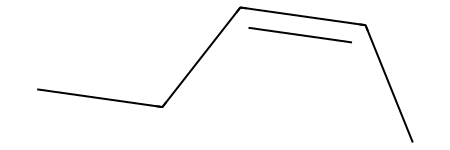

In [4]:
Chem.MolFromSmiles(data['smiles'][0])

We will re-implement the D-MPNN from the slides here. First, we need to transform our RDKit molecule objects to graphs with edge (bond) and node (atom) features. Here, we use a simply one-hot encoding of symbol, degree, hydrogen atoms, hybridization, and aromaticity (vector size = 29). For bond features, we simply use the bond type, and whether it is conjugated and in a ring (vector size = 6). In general, this initial featurization should be adapted for more complex problems.

In [5]:
def atom_features(atom):
    features = onek_encoding_unk(atom.GetSymbol(), ['C', 'N', 'O',  'P', 'S', 'Cl', 'Br', 'I']) + \
        onek_encoding_unk(atom.GetTotalDegree(), [0, 1, 2, 3, 4, 5]) + \
        onek_encoding_unk(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4]) + \
        onek_encoding_unk(int(atom.GetHybridization()),[Chem.rdchem.HybridizationType.SP,
                                                        Chem.rdchem.HybridizationType.SP2,
                                                        Chem.rdchem.HybridizationType.SP3,
                                                        Chem.rdchem.HybridizationType.SP3D,
                                                        Chem.rdchem.HybridizationType.SP3D2
                                                        ]) + \
        [1 if atom.GetIsAromatic() else 0]
    return features

def bond_features(bond):
    bt = bond.GetBondType()
    fbond = [
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
      ]
    return fbond

def onek_encoding_unk(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

In [6]:
class MolGraph:
    def __init__(self, smiles):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = Chem.MolFromSmiles(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_features(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_features(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

In [7]:
g = MolGraph("CCO")
for i,f in enumerate(g.f_atoms):
  print(i,f)
for (i,j),f in zip(g.edge_index,g.f_bonds):
  print(i,j,f)

0 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
1 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
2 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
0 1 [True, False, False, False, False, False]
1 0 [True, False, False, False, False, False]
1 2 [True, False, False, False, False, False]
2 1 [True, False, False, False, False, False]


For a dataset of molecules and their properties, we can now build a dataset object, and a loader which inherit from pytorch_geometric's Dataset and DataLoader. The ChemDataset class takes as input a list of SMILES and target values. Whenever we retrieve an element from this list via the get() function, we create a MolGraph from the respective SMILES strings. For this course, we do not implement any caching, but remake the graphs whenever we need them (we also don't hold them in memory). The molgraph2data function transforms our custom MolGraph into a format more convenient for pytorch_geometric's functionalities (and, importantly, into torch tensors). The construct_loader() functions takes a CSV file saved locally or from the internet, and uses the first column as list of SMILES, and the second as list of targets, for the sake of simplicity (for a real software package, don't hardcode this!)

In [8]:
class ChemDataset(Dataset):
    def __init__(self, smiles, labels):
        super(ChemDataset, self).__init__()
        self.smiles = smiles
        self.labels = labels

    def process_key(self, key):
        smi = self.smiles[key]
        mol = self.molgraph2data(MolGraph(smi), key)
        return mol

    def molgraph2data(self, molgraph, key):
        data = tg.data.Data()
        data.x = torch.tensor(molgraph.f_atoms, dtype=torch.float)
        data.edge_index = torch.tensor(molgraph.edge_index, dtype=torch.long).t().contiguous()
        data.edge_attr = torch.tensor(molgraph.f_bonds, dtype=torch.float)
        data.y = torch.tensor([self.labels[key]], dtype=torch.float)
        data.smiles = self.smiles[key]
        return data

    def get(self,key):
        return self.process_key(key)

    def len(self):
        return len(self.smiles)

def construct_loader(data_path, shuffle=True, batch_size=50):
    data_df = pd.read_csv(data_path)
    smiles = data_df.iloc[:, 0].values
    labels = data_df.iloc[:, 1].values.astype(np.float32)
    dataset = ChemDataset(smiles, labels)
    loader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=0,
                            pin_memory=True,
                            sampler=None)
    return loader

Let us now construct a D-MPNN (directed message-passing neural network) based on pytorch_geometric. We will follow the framework of Chemprop for the implementation in this workshop, but there are many flavors of D-MPNNs differing in the messages, update functions, etc. Based on the edge_index list we provide in our dataset, pytorch_geometric does all the heavy lifting determining which pairs of atoms should pass messages, and which sets of atoms to aggregate over to make molecular from atomic embeddings.

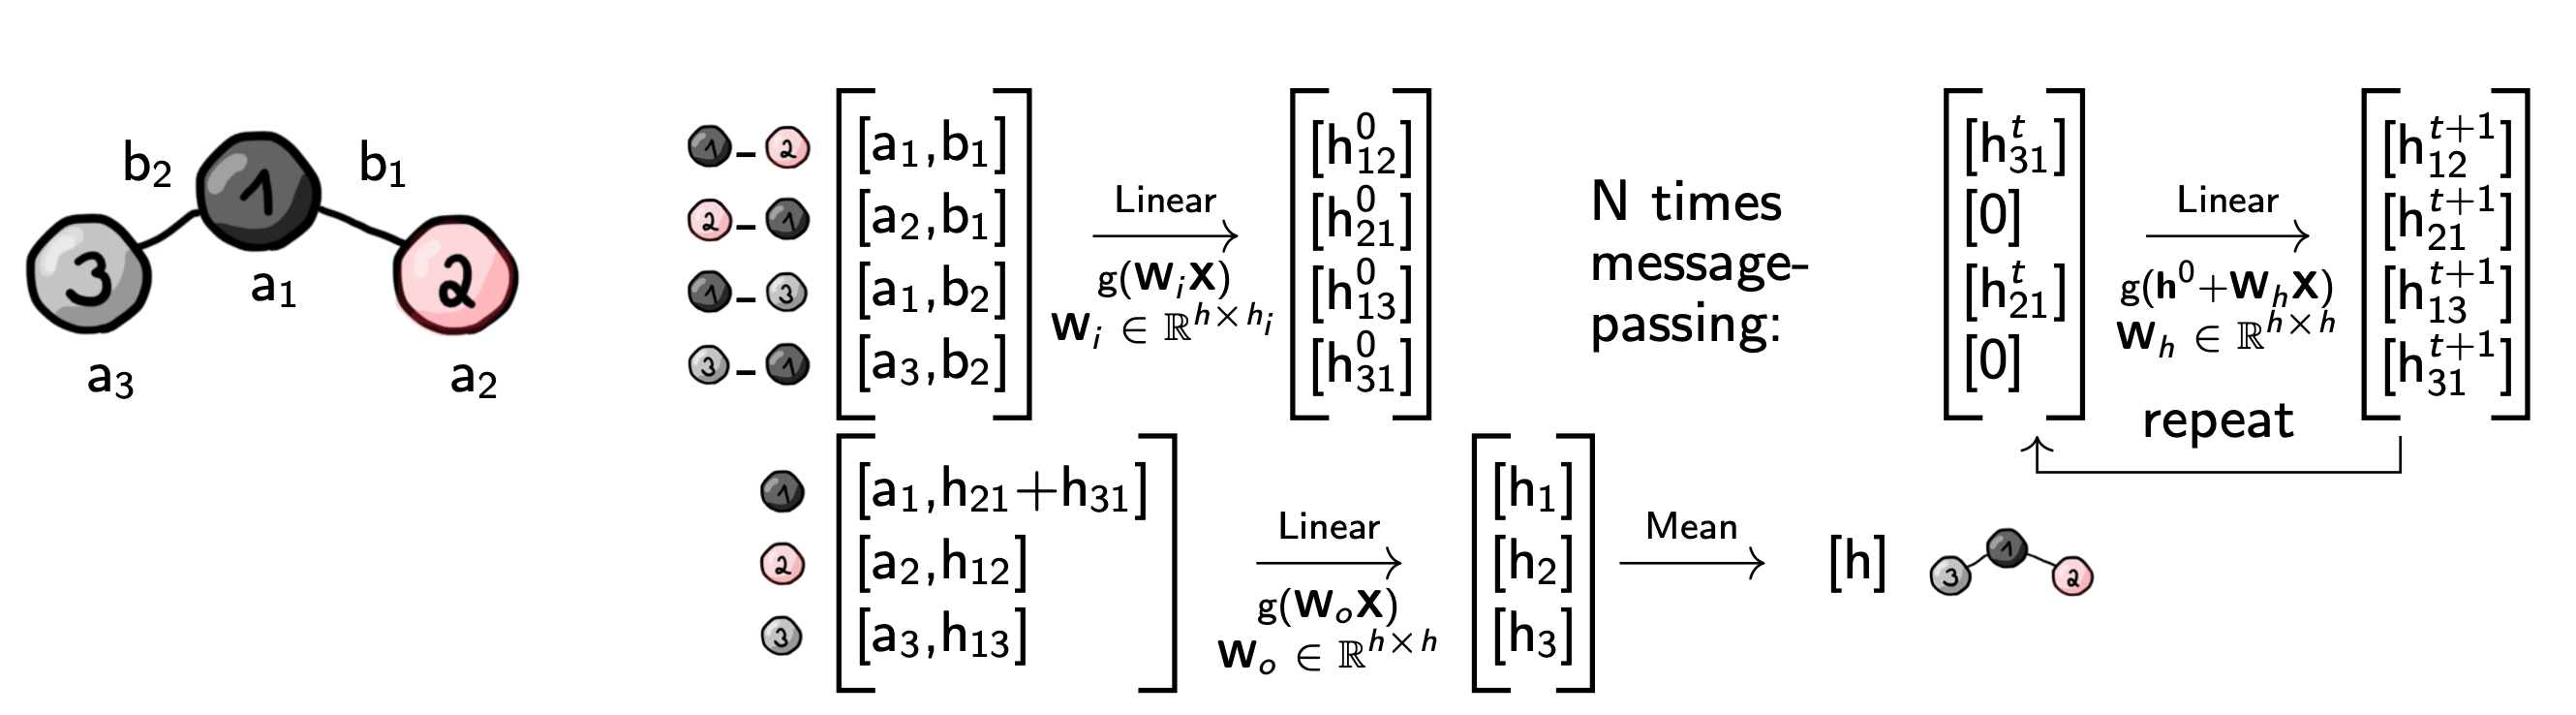

In [9]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()

        self.depth = 3
        self.hidden_size = 300
        self.dropout = 0.02

        self.edge_init = nn.Linear(num_node_features + num_edge_features, self.hidden_size)
        self.convs = torch.nn.ModuleList()
        for _ in range(self.depth):
            self.convs.append(DMPNNConv(self.hidden_size))
        self.edge_to_node = nn.Linear(num_node_features + self.hidden_size, self.hidden_size)
        self.pool = global_add_pool
        self.ffn = nn.Linear(self.hidden_size, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # initial edge features
        row, col = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # convolutions
        for l in range(self.depth):
            _, h = self.convs[l](edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # dmpnn edge -> node aggregation
        s, _ = self.convs[l](edge_index, h) #only use for summing
        q  = torch.cat([x,s], dim=1)
        h = F.relu(self.edge_to_node(q))
        return self.ffn(self.pool(h, batch)).squeeze(-1)

class DMPNNConv(MessagePassing):
    def __init__(self, hidden_size):
        super(DMPNNConv, self).__init__(aggr='add')
        self.lin = nn.Linear(hidden_size, hidden_size)

    def forward(self, edge_index, edge_attr):
        row, col = edge_index
        a_message = self.propagate(edge_index, x=None, edge_attr=edge_attr)
        rev_message = torch.flip(edge_attr.view(edge_attr.size(0) // 2, 2, -1), dims=[1]).view(edge_attr.size(0), -1)

        return a_message, self.lin(a_message[row] - rev_message)

    def message(self, edge_attr):
        return edge_attr

In [10]:
GNN(29,6)

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)

In [13]:
def train_epoch(model, loader, optimizer, loss):
    model.train()
    loss_all = 0

    for data in loader:
        optimizer.zero_grad()

        out = model(data)
        result = loss(out, data.y)
        result.backward()

        optimizer.step()
        loss_all += loss(out, data.y)

    return math.sqrt(loss_all / len(loader.dataset))

def pred(model, loader, loss):
    model.eval()

    preds, ys = [], []
    with torch.no_grad():
        for data in loader:
            pred = model(data)
            preds.extend(pred.cpu().detach().tolist())

    return preds

def train(folder):
    torch.manual_seed(0)
    train_loader = construct_loader(folder+"/train_full.csv", True)
    val_loader = construct_loader(folder+"/val_full.csv", False)
    test_loader = construct_loader(folder+"/test_full.csv", False)


    model = GNN(train_loader.dataset.num_node_features, train_loader.dataset.num_edge_features)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss(reduction='sum')
    print(model)

    for epoch in range(0, 30):
        train_loss = train_epoch(model, train_loader, optimizer, loss)
        preds = pred(model, val_loader, loss)
        print("Epoch",epoch,"  Train RMSE", train_loss,"   Val RMSE", root_mean_squared_error(preds,val_loader.dataset.labels))

    preds = pred(model, test_loader, loss)
    print("Test RMSE", root_mean_squared_error(preds,test_loader.dataset.labels))
    print("Test MAE", mean_absolute_error(preds,test_loader.dataset.labels))

In [14]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 4.571772102663409    Val RMSE 1.6822713613510132
Epoch 1   Train RMSE 1.629827079025758    Val RMSE 1.5634512901306152
Epoch 2   Train RMSE 1.3604469457569976    Val RMSE 1.374569296836853
Epoch 3   Train RMSE 1.2057019169517806    Val RMSE 1.0492404699325562
Epoch 4   Train RMSE 1.056599727269256    Val RMSE 0.9475681781768799
Epoch 5   Train RMSE 0.9899333067306085    Val RMSE 0.9272180795669556
Epoch 6   Train RMSE 0.9675951195811794    Val RMSE 0.9151182770729065
Epoch 7   Train RMSE 0.9331640427758001    Val RMSE 0.8943478465080261
Epoch 8   Train RMSE 0.9393933251396158    Val RMSE 0.8709297180175781
Epoch 9   Train RMSE 0.9189359723223525    Val RMSE 0.8600962162017822
Epoch 10   Train RMSE 0.91106493861

# Modifications

We can now make any modifications we want, for example by introducing an attention layer before the feed-forward neural network:

In [15]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()

        self.depth = 3
        self.hidden_size = 300
        self.dropout = 0.02

        self.edge_init = nn.Linear(num_node_features + num_edge_features, self.hidden_size)
        self.convs = torch.nn.ModuleList()
        for _ in range(self.depth):
            self.convs.append(DMPNNConv(self.hidden_size))
        self.edge_to_node = nn.Linear(num_node_features + self.hidden_size, self.hidden_size)
        self.pool = global_add_pool
        self.att = MultiheadAttention(self.hidden_size, 2)
        self.ffn = nn.Linear(self.hidden_size*2, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # initial edge features
        row, col = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # convolutions
        for l in range(self.depth):
            _, h = self.convs[l](edge_index, h)
            h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # dmpnn edge -> node aggregation
        s, _ = self.convs[l](edge_index, h) #only use for summing
        q  = torch.cat([x,s], dim=1)
        h = F.relu(self.edge_to_node(q))
        hmol = self.pool(h, batch)
        attn_output, attn_output_weights =  self.att(hmol, hmol, hmol)
        return self.ffn(torch.cat([hmol, attn_output], dim=1)).squeeze(-1)

In [16]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (att): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
  )
  (ffn): Linear(in_features=600, out_features=1, bias=True)
)
Epoch 0   Train RMSE 2.3334454668439584    Val RMSE 1.5891211032867432
Epoch 1   Train RMSE 1.3907649794859924    Val RMSE 1.2921817302703857
Epoch 2   Train RMSE 1.1619259986129695    Val RMSE 0.9721678495407104
Epoch 3   Train RMSE 1.0341345585386263    Val RMSE 0.996239423751831
Epoch 4   Train RMSE 1.0070637131719598    Val RMSE 1.0395759344100952
Epoch 5   Train RMSE 0.9915325676517543    Val RMSE 0.8937274813652039
Epoch 6   Train RMSE 0.9319560798459391    Val RMSE 1.249057412147522
Epoch 7   Train RMSE 1.0823399623244512    Val RMSE 1.147770881652832
Epoch 8   Train RMSE 0.9508649264198573    Val RM

Or, instead of adding up the initial and current messages in message passing, we can concatenate them and pass them through a single layer to get back to the correct dimensions:

In [17]:
class GNN(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(GNN, self).__init__()

        self.depth = 3
        self.hidden_size = 300
        self.dropout = 0.02

        self.edge_init = nn.Linear(num_node_features + num_edge_features, self.hidden_size)
        self.convs = torch.nn.ModuleList()
        for _ in range(self.depth):
            self.convs.append(DMPNNConv(self.hidden_size))
        self.edge_to_node = nn.Linear(num_node_features + self.hidden_size, self.hidden_size)
        self.pool = global_add_pool
        self.my_layer = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.ffn = nn.Linear(self.hidden_size, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # initial edge features
        row, col = edge_index
        h_0 = F.relu(self.edge_init(torch.cat([x[row], edge_attr], dim=1)))
        h = h_0

        # convolutions
        for l in range(self.depth):
            _, h = self.convs[l](edge_index, h)
            h = self.my_layer(torch.cat([h, h_0],dim=1)) # h += h_0
            h = F.dropout(F.relu(h), self.dropout, training=self.training)

        # dmpnn edge -> node aggregation
        s, _ = self.convs[l](edge_index, h) #only use for summing
        q  = torch.cat([x,s], dim=1)
        h = F.relu(self.edge_to_node(q))
        return self.ffn(self.pool(h, batch)).squeeze(-1)

In [18]:
train("https://github.com/hesther/rxn_workshop/raw/main/data/esol")

GNN(
  (edge_init): Linear(in_features=35, out_features=300, bias=True)
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=329, out_features=300, bias=True)
  (my_layer): Linear(in_features=600, out_features=300, bias=True)
  (ffn): Linear(in_features=300, out_features=1, bias=True)
)
Epoch 0   Train RMSE 1.744631776078664    Val RMSE 1.3351149559020996
Epoch 1   Train RMSE 1.2176833253266235    Val RMSE 1.1200032234191895
Epoch 2   Train RMSE 1.0873835424571576    Val RMSE 1.1001598834991455
Epoch 3   Train RMSE 1.0501158355214917    Val RMSE 0.9910396337509155
Epoch 4   Train RMSE 0.9671403371130493    Val RMSE 0.8474486470222473
Epoch 5   Train RMSE 0.8996736067096357    Val RMSE 0.9006795883178711
Epoch 6   Train RMSE 0.8757931656584088    Val RMSE 0.7338083386421204
Epoch 7   Train RMSE 0.8203309193314312    Val RMSE 0.7468587756156921
Epoch 8   Train RMSE 0.7865744540822107    Val RMSE 0.9752132296562195
Epoch 9   Train RMSE 0.8238170784019